In [1]:
# Source: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from time import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

In [2]:
n_features = 2000
n_components = 6
n_top_words = 20
batch_size = 128
init = "nndsvda"

In [3]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, (n_components + 1) // 2, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [4]:
print("Loading dataset...")
t0 = time()
tweets_df = pd.read_csv('data/elon_prepared_tweets.csv', index_col='id')[['date', 'text', 'cleared_text']]
print("done in %0.3fs." % (time() - t0))
tweets_df.head()

Loading dataset...
done in 0.893s.


,date,text,cleared_text
id,,,
1211071324518531072,2019-12-28,@Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...,this is a pretty awful lie i left south africa...
1211069054779301894,2019-12-28,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,this person blocked me so can t read the tweet...
1211064937004589056,2019-12-28,@IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...,we started zip2 with 2k from me plus my overcl...
1211054942192119808,2019-12-28,@tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...,he didn t own an emerald mine i worked my way ...
1211051740562366464,2019-12-28,@geofficient Pretty much,pretty much


In [5]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(tweets_df.cleared_text)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(tweets_df.cleared_text)
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
done in 0.225s.
Extracting tf features for LDA...
done in 0.141s.


Fitting the NMF model (Frobenius norm) with tf-idf features, n_features=2000...
done in 0.289s.


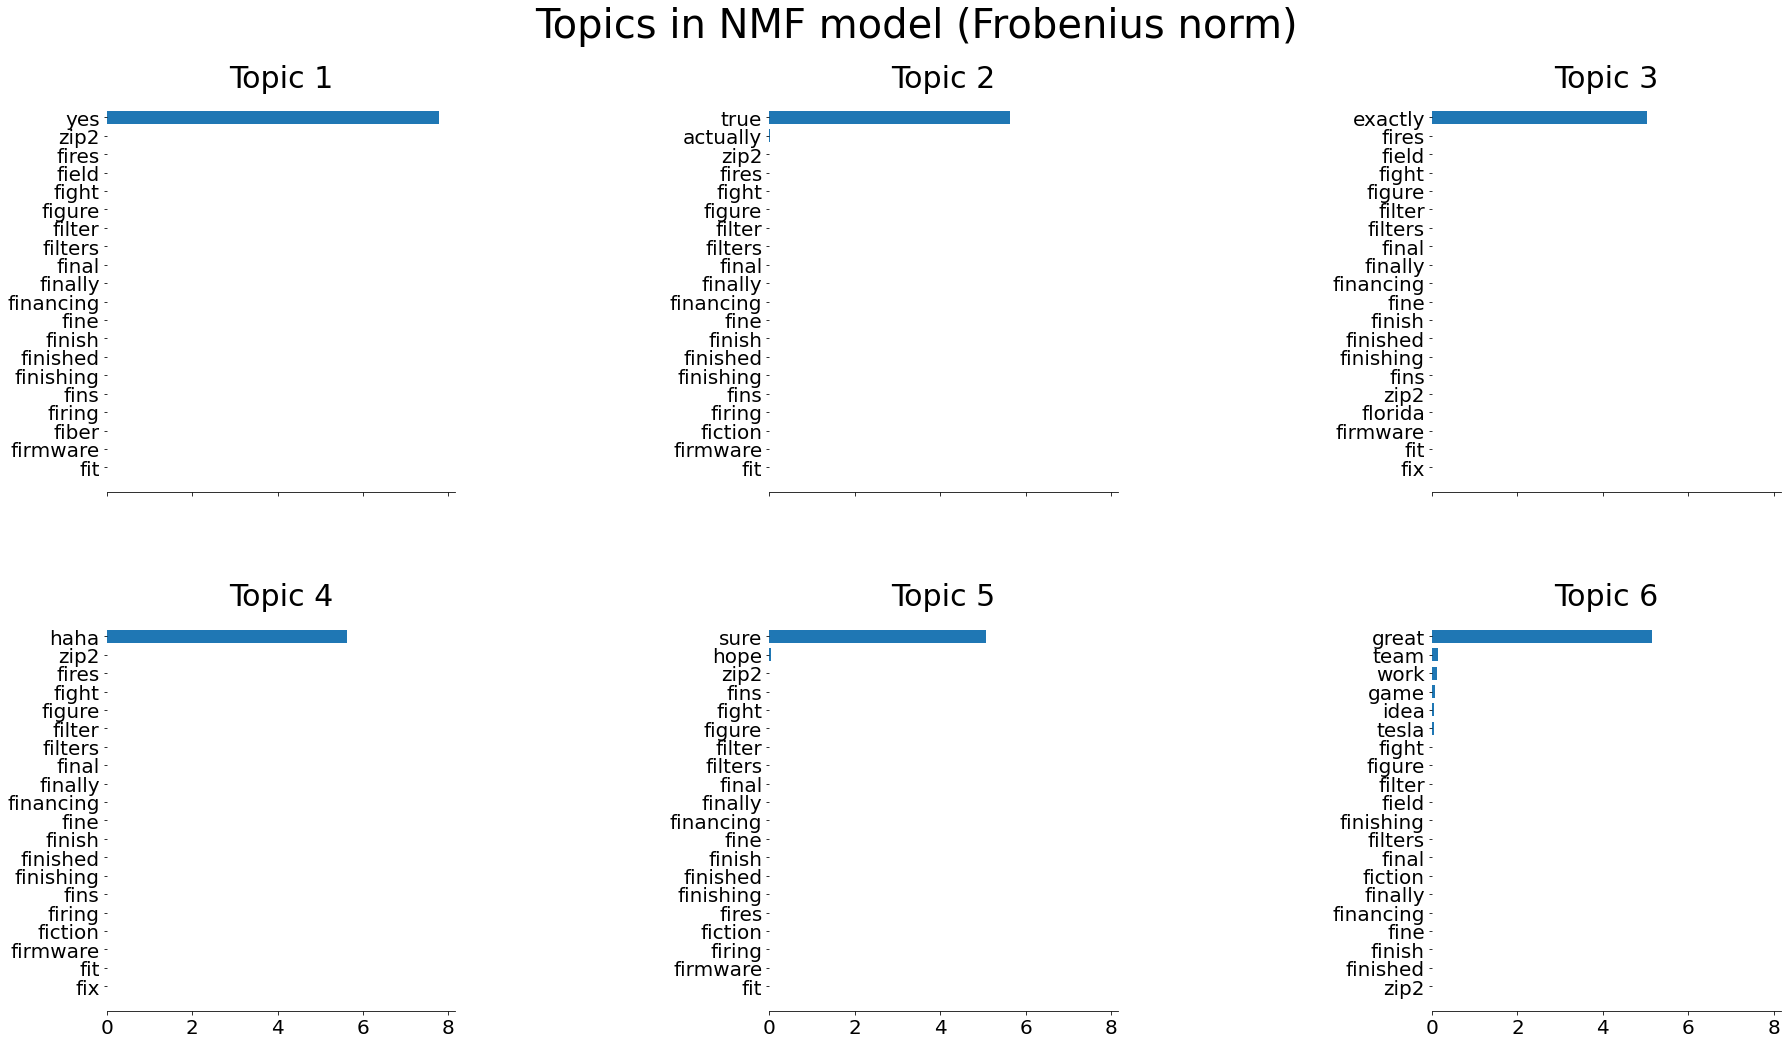

In [6]:
# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_features=%d..." % (n_features, )
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_features=2000...
done in 2.367s.


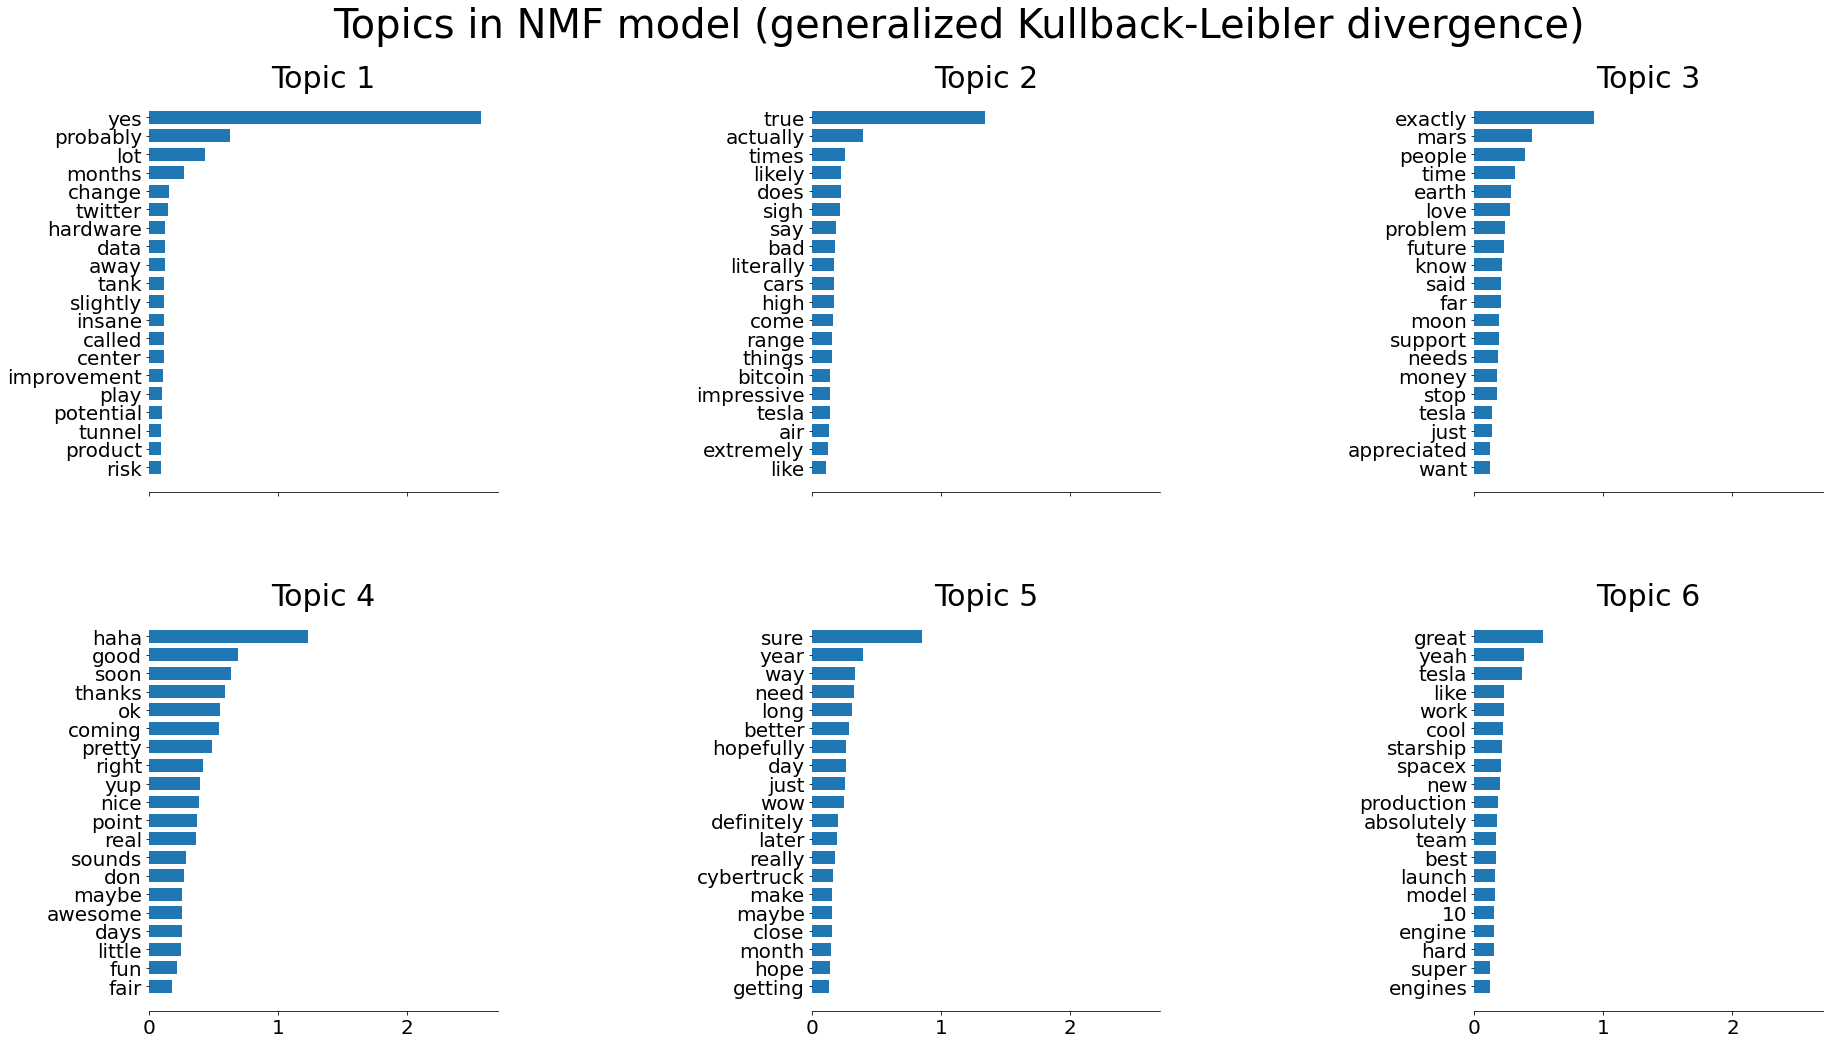

In [7]:
# Fit the NMF model
print(
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_features=%d..."
    % (n_features, ),
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_features=2000, batch_size=128...
done in 0.125s.


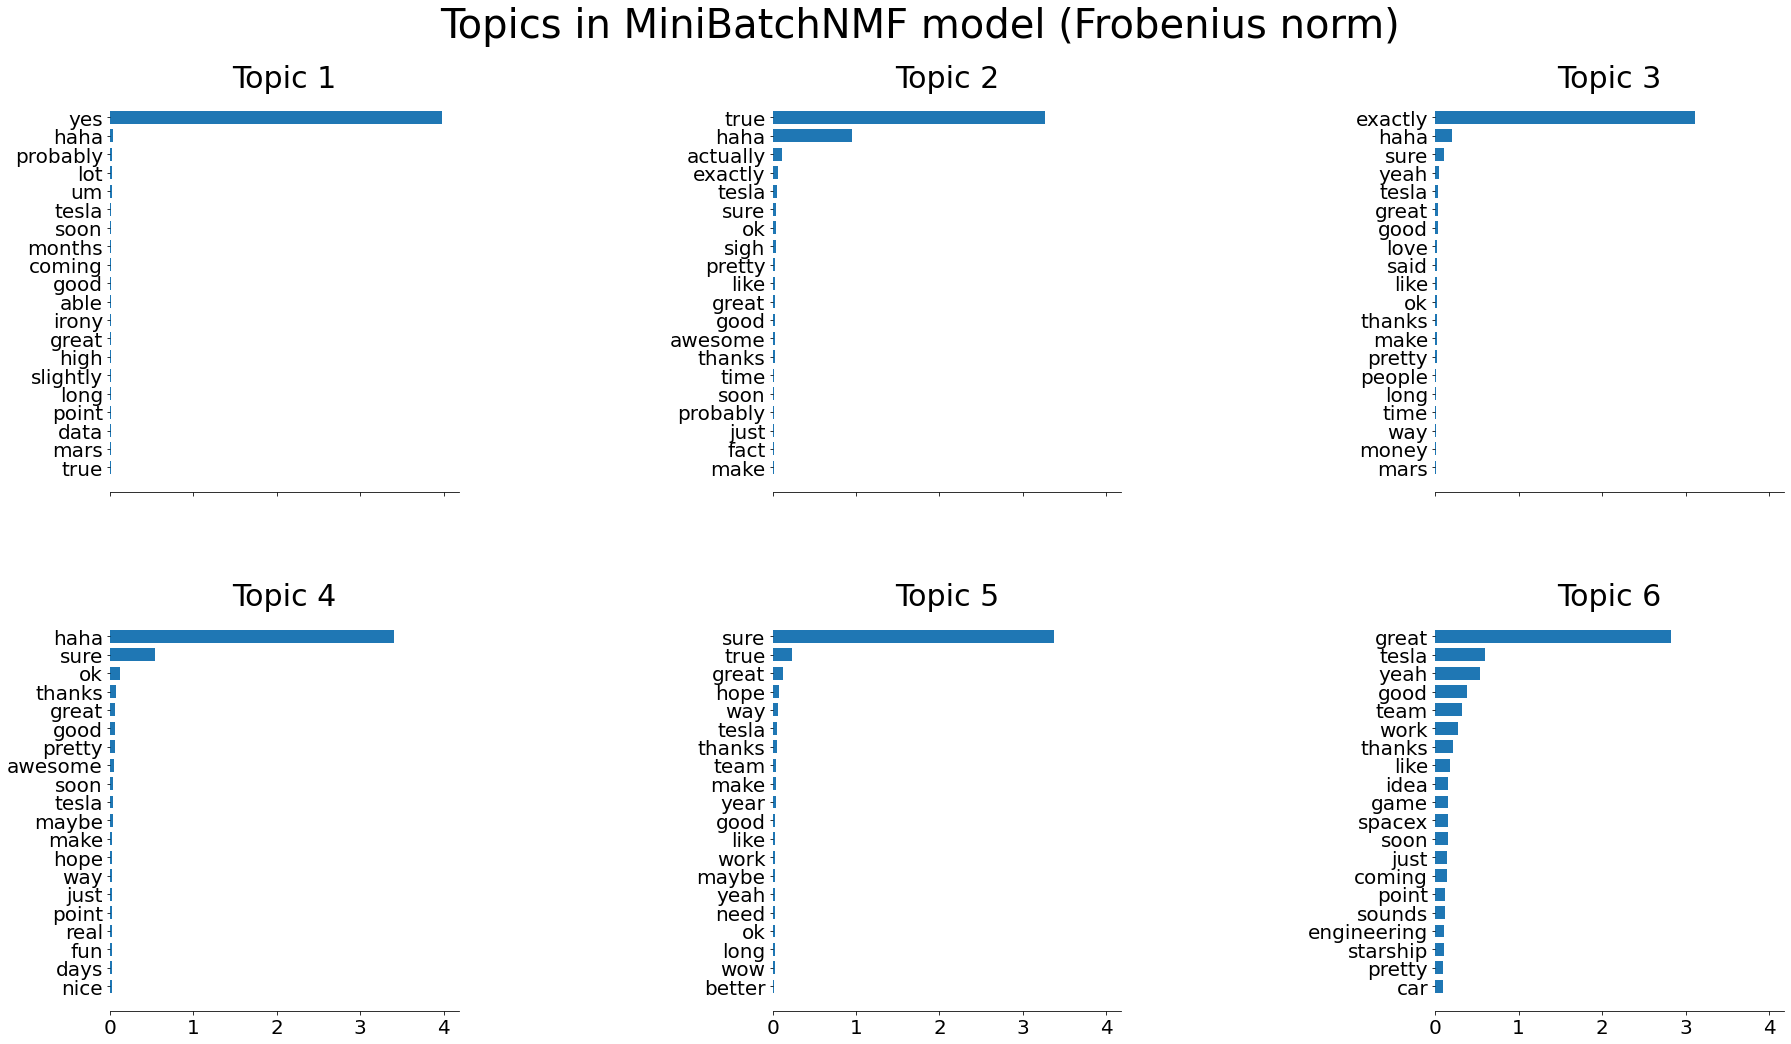

In [8]:
# Fit the MiniBatchNMF model
print(
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_features=%d, batch_size=%d..."
    % (n_features, batch_size),
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_features=2000, batch_size=128...
done in 0.577s.


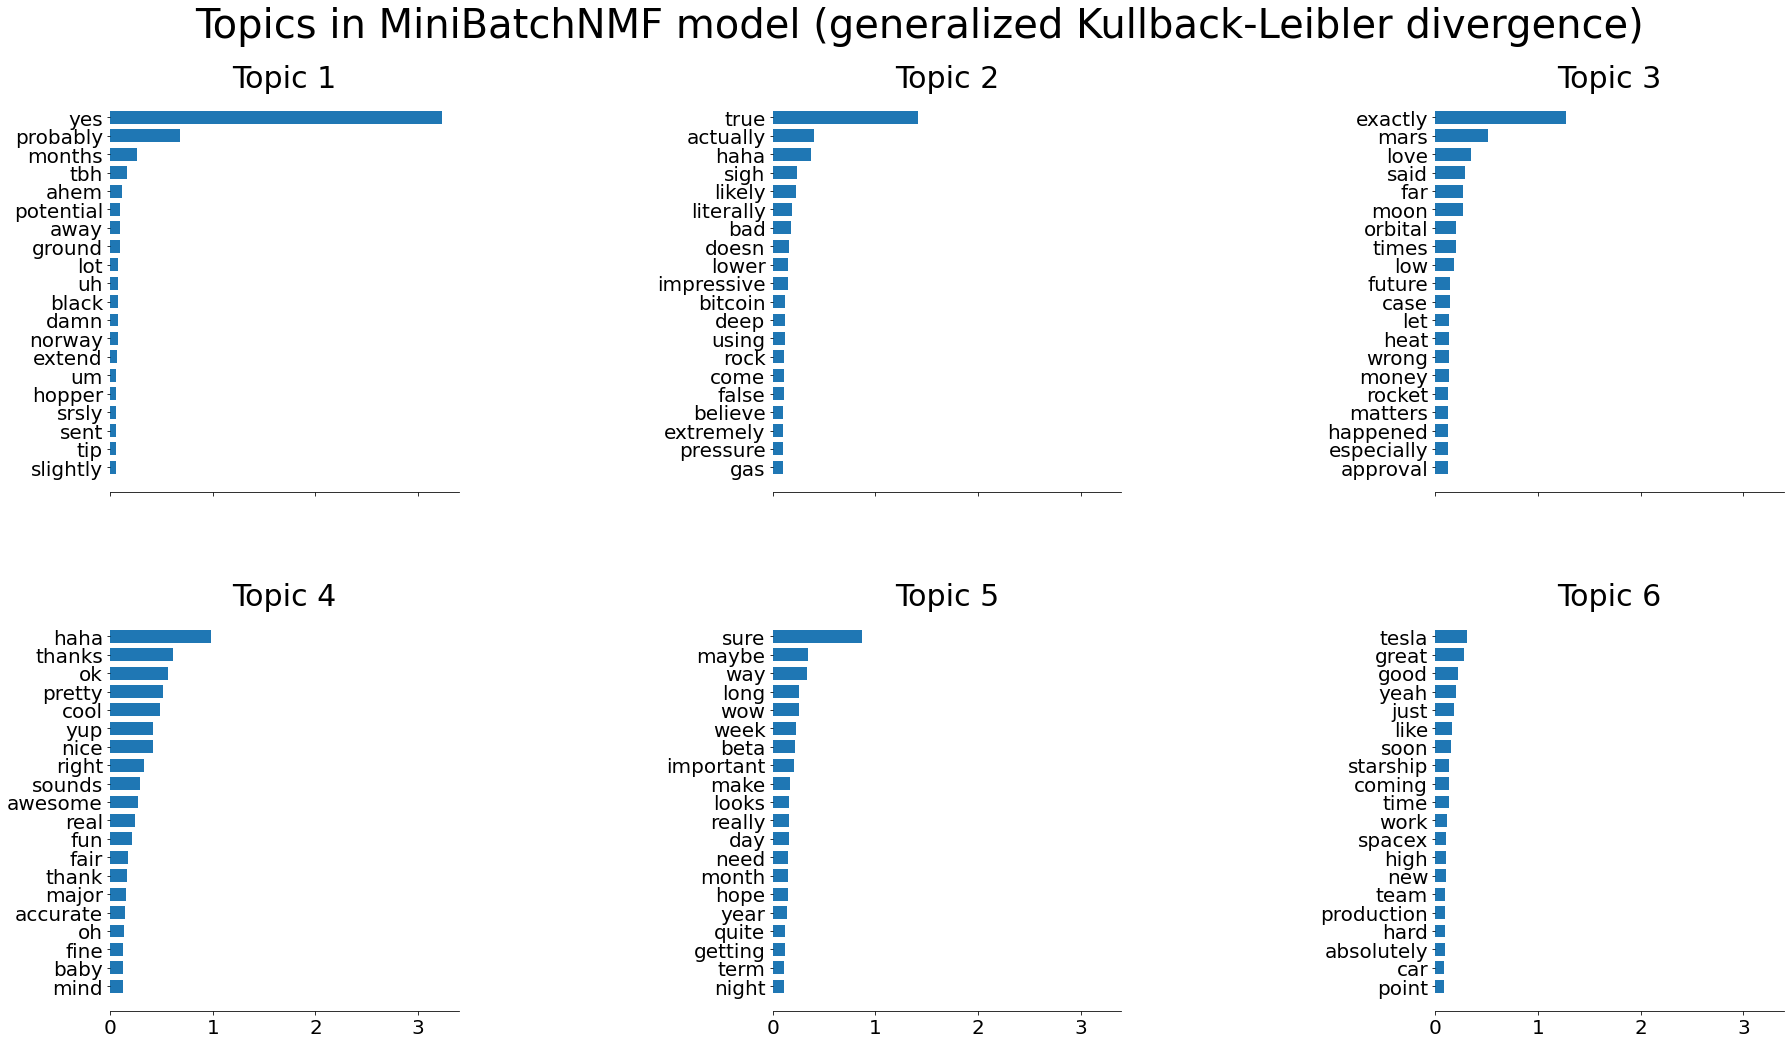

In [9]:
# Fit the MiniBatchNMF model
print(
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_features=%d, "
    "batch_size=%d..." % (n_features, batch_size),
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

Fitting LDA models with tf features, n_features=2000...
done in 7.139s.


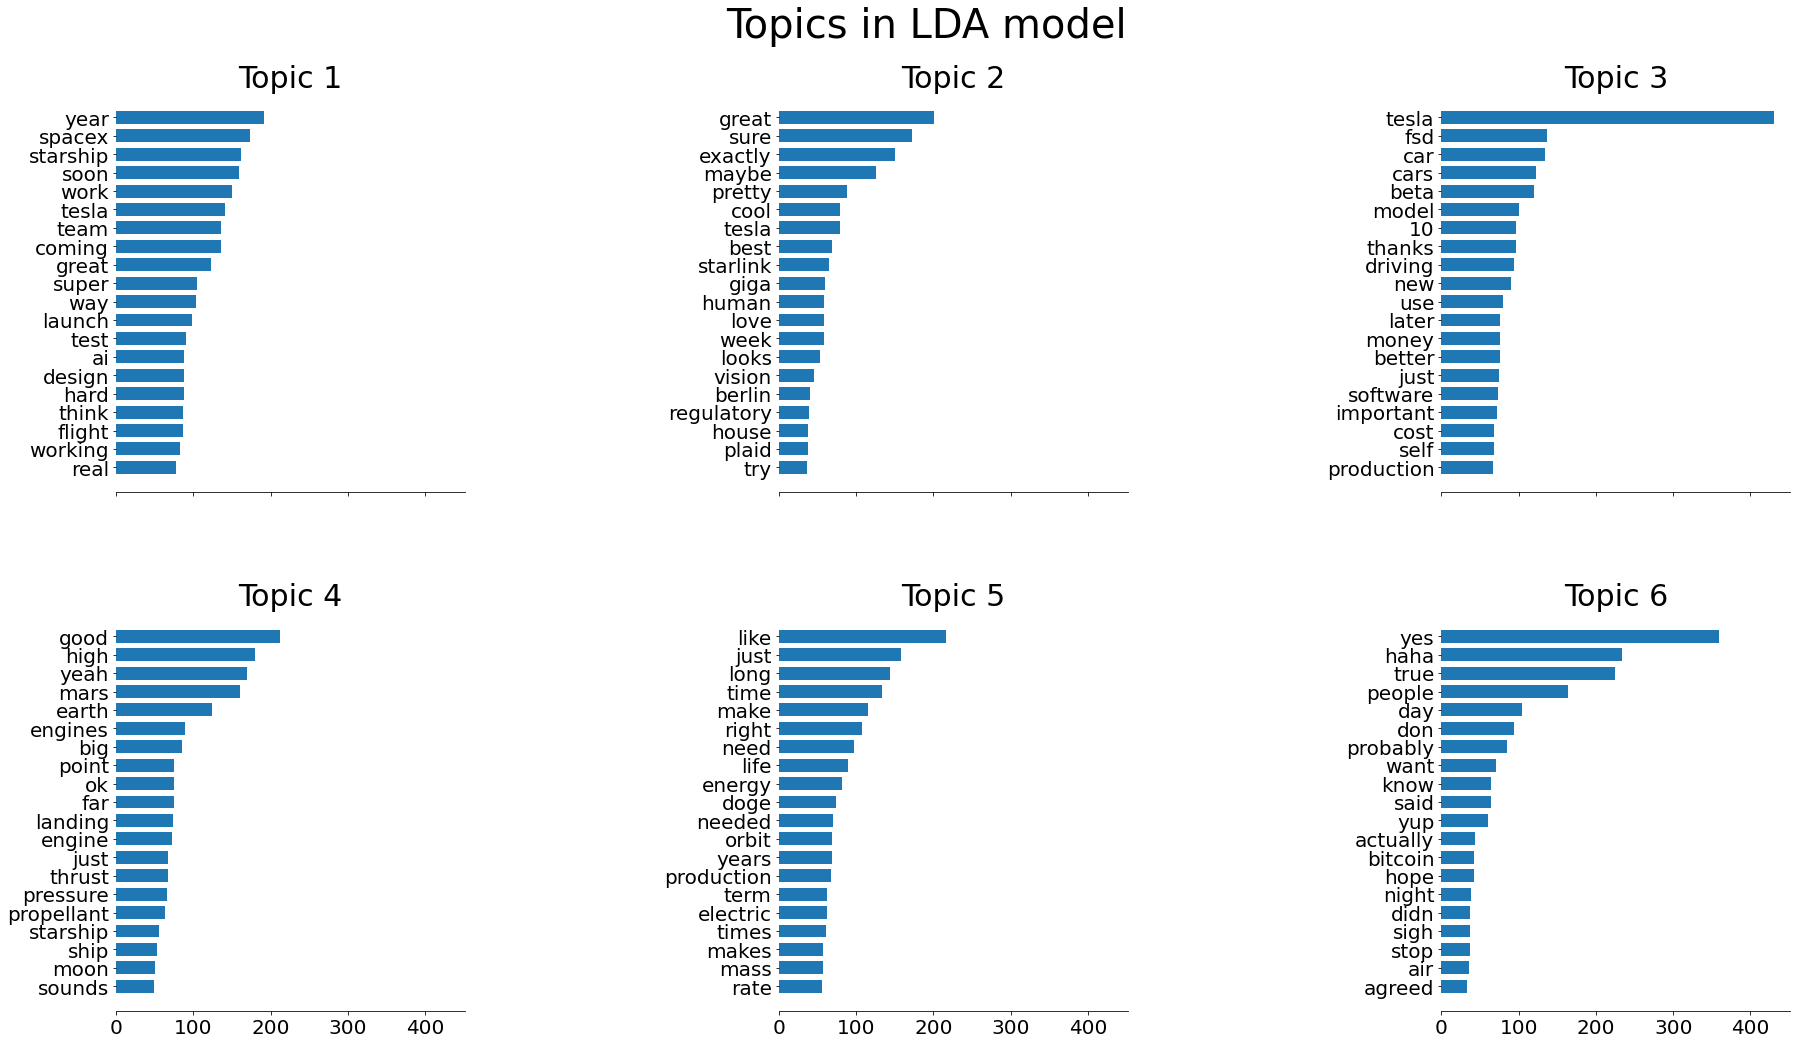

In [10]:
print(
    "Fitting LDA models with tf features, n_features=%d..."
    % (n_features, ),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")